In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

## Initialising global variables

In [2]:
# Arrays containing the names of the card suits and ranks   
ranks = ['Ace','Two','Three','Four','Five','Six','Seven','Eight','Nine','Ten','Jack','Queen','King']
suits = ['Spades', 'Clubs', 'Diamonds', 'Hearts']


### Template Class

In [3]:
class template:
    def __init__(self,name,image):
        self.name = name
        self.image = image

### Card Class

In [4]:
class Card:
    def __init__(self):
        self.contour = [] # Contour of card
        self.width, self.height = 0, 0 # Width and height of card
        self.corner_points = [] # Corner points of card
        self.center = [] # Center point of card
        self.aligned = [] # 200x300, flattened, grayed, blurred image
        self.rank_img = [] # Thresholded, sized image of card's rank
        self.suit_img = [] # Thresholded, sized image of card's suit
        self.rank_pred = "Unknown" # Best matched rank
        self.suit_pred = "Unknown" # Best matched suit

### Initialise template

In [5]:
# loading the template into arrays

def Initialise_templates(path): 
    
    rank_templates, suit_templates = [], []
    for rank in ranks:
        file_path = path + rank + ".jpg"
        image = cv2.imread(file_path,0)
        rank_templates.append(template(rank,image))
    
    for suit in suits:
        file_path = path + suit + ".jpg"
        image = cv2.imread(file_path,0)
        suit_templates.append(template(suit,image))
    
    return rank_templates, suit_templates


### Threshold function

In [6]:
def threshold(img,t):
    image = img.copy()
    image = cv2.GaussianBlur(image, (19, 19), 0)
    _, thresholded = cv2.threshold(image, t, 255, cv2.THRESH_BINARY)
    # thresholded = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  
    return thresholded

### Find Card Function

In [7]:
# checks for cards (rectangles) present in the images by using contouring

def find_card(img): #send in the thresholded image of the card
    
    CARD_AREA_MAX = 9000000
    CARD_AREA_MIN = 70000
    contours,hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #finding contours
    
    if len(contours) == 0:
        return [], []
    
    card_contour_check = np.zeros(len(contours), dtype=int)
    
    index_sort = np.argsort([cv2.contourArea(c) for c in contours], kind='mergesort')[::-1] #sorting according to contour area
    contours_arranged = [contours[i] for i in index_sort]
    hierarchy_arranged = [hierarchy[0][i] for i in index_sort]

    # Checking if we think the contour is a card 

    for i in range(len(contours_arranged)): 
        if(cv2.contourArea(contours_arranged[i]) > CARD_AREA_MIN and cv2.contourArea(contours_arranged[i]) < CARD_AREA_MAX):
            # print("area sufficient")
            if(hierarchy_arranged[i][3] == -1):
                # print("no parent")
                if(cv2.approxPolyDP(contours_arranged[i], 0.01*cv2.arcLength(contours_arranged[i], True), True).shape[0] == 4):
                    # print("polygon")
                    card_contour_check[i] = 1
    
    return contours_arranged, card_contour_check


### Align Card Function

In [8]:
def align(img,points,dimensions):
    rect = np.zeros((4,2), dtype = "float32")
    s = np.sum(points, axis = 2)
    tl = points[np.argmin(s)]
    br = points[np.argmax(s)]

    diff = np.diff(points, axis = -1)
    tr = points[np.argmin(diff)]
    bl = points[np.argmax(diff)]

    w = dimensions[0]
    h = dimensions[1]

    if w <= 0.8*h: # If card is vertically oriented
        rect[0] = tl
        rect[1] = tr
        rect[2] = br
        rect[3] = bl

    if w >= 1.2*h: # If card is horizontally oriented
        rect[0] = bl
        rect[1] = tl
        rect[2] = tr
        rect[3] = br

    if w > 0.8*h and w < 1.2*h: #If card is diamond oriented
        # If furthest left point is higher than furthest right point,
        # card is tilted to the left.
        if points[1][0][1] <= points[3][0][1]:
            # If card is titled to the left, approxPolyDP returns points
            # in this order: top right, top left, bottom left, bottom right
            rect[0] = points[1][0] # Top left
            rect[1] = points[0][0] # Top right
            rect[2] = points[3][0] # Bottom right
            rect[3] = points[2][0] # Bottom left

        # If furthest left point is lower than furthest right point,
        # card is tilted to the right
        if points[1][0][1] > points[3][0][1]:
            # If card is titled to the right, approxPolyDP returns points
            # in this order: top left, bottom left, bottom right, top right
            rect[0] = points[0][0] # Top left
            rect[1] = points[3][0] # Top right
            rect[2] = points[2][0] # Bottom right
            rect[3] = points[1][0] # Bottom left
            
        
    maxWidth = 200
    maxHeight = 300

    # Create destination array, calculate perspective transform matrix,
    # and warp card image
    dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0,maxHeight-1]],np.float32)
    M = cv2.getPerspectiveTransform(rect,dst)
    aligned = cv2.warpPerspective(img,M,(maxWidth,maxHeight))

    return aligned


### Extract Card Function

In [9]:
def find_corners(contour): #finds the corner of the card
    point = cv2.approxPolyDP(contour, 0.01*cv2.arcLength(contour, True), True) #gives us the approximate polygon that might be the contours shape
    corner_points = np.float32(point)

    # print("Corners")
    # print(corner_points)

    x_center, y_center = (np.sum(corner_points, axis=0)/len(corner_points))[0]
    x_center, y_center = int(x_center), int(y_center)

    return corner_points, [x_center, y_center]

def find_rank_suit(card): #extracts the corner and the rank and suit
    CORNER_WIDTH = 32
    CORNER_HEIGHT = 84

    corner = card.aligned[0:CORNER_HEIGHT, 0:CORNER_WIDTH]
    corner_zoom = cv2.resize(corner, (0,0), fx=4, fy=4)
    _, inverted = cv2.threshold(corner_zoom, 0, 255, cv2.THRESH_BINARY_INV)
    
    card_rank = inverted[20:185, 0:128]
    card_suit = inverted[186:336, 0:128]

    #contouring on the rank and suit 
    rank_contour, _ = cv2.findContours(card_rank, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    suit_contour, _ = cv2.findContours(card_suit, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    rank_contour = sorted(rank_contour, key=cv2.contourArea, reverse=True)
    suit_contour = sorted(suit_contour, key=cv2.contourArea, reverse=True)

    w_rank = 70
    h_rank = 125

    w_suit = 70
    h_suit = 100

    # appending their bounding rectangles
    
    if len(rank_contour) != 0:
        x,y,w,h = cv2.boundingRect(rank_contour[0])
        card.rank_img = cv2.resize(card_rank[y:y+h, x:x+w], (w_rank, h_rank), 0,0)

    if len(suit_contour) != 0:
        x,y,w,h = cv2.boundingRect(suit_contour[0])
        card.suit_img = cv2.resize(card_suit[y:y+h, x:x+w], (w_suit, h_suit), 0,0)

In [10]:
def extract_card(contour, card_img):
    card = Card()
    _, _, card.width, card.height = cv2.boundingRect(contour)

    card.corner_points, card.center = find_corners(contour)
    card.aligned = align(card_img, card.corner_points, [card.width, card.height])

    # plt.imshow(card.aligned, cmap='gray')
    
    find_rank_suit(card)

    return card 

### Template Matching

In [11]:
# The function finds the closest features that match the input card's features using absolute difference

def template_matching(card, rank_templates, suit_templates):
    best_rank_match_diff = 1500
    best_suit_match_diff = 1500

    best_rank_match_name = ""
    best_suit_match_name = ""

    for rank in rank_templates:
        diff = cv2.absdiff(card.rank_img, rank.image)
        
        rank_diff = int(np.sum(diff)/255)
        # print(rank.name)
        # print(rank_diff)
        if rank_diff < best_rank_match_diff:
            best_rank_match_diff = rank_diff
            best_rank_match_name = rank.name

    for suit in suit_templates:
        diff = cv2.absdiff(card.suit_img, suit.image)
      
        suit_diff = int(np.sum(diff)/255)
        # print(suit.name)
        # print(suit_diff)
        if suit_diff < best_suit_match_diff:
            best_suit_match_diff = suit_diff
            best_suit_match_name = suit.name

    if(best_rank_match_name == "" or best_suit_match_name == ""):
        card.rank_pred = "Unknown"
        card.suit_pred = "Card"
        return card
    
    card.rank_pred = best_rank_match_name
    card.suit_pred = best_suit_match_name

    return card

## Saving rank and suit templates

In [12]:
#saving rank and suit templates

arr1 = ['A','2','3','4','5','6','7','8','9','10','J','Q','K']
arr2 = ['spades', 'clubs', 'diamonds', 'hearts']

for suit in arr2:
    image_in = cv2.imread("Train_Data_uncompressed/"+'A'+"_"+suit+".jpg",0)
    thresholded = threshold(image_in,150) 
    cards,card_contour_check = find_card(thresholded)
    for i, c in enumerate(cards):
            if card_contour_check[i] == 1:
                card = extract_card(cards[i], thresholded)
    
    cv2.imwrite("self_data/"+suit+".jpg",card.suit_img)

for rank in arr1:
    image_in = cv2.imread("Train_Data_uncompressed/"+rank+"_"+"clubs"+".jpg",0)
    thresholded = threshold(image_in,150) 
    cards,card_contour_check = find_card(thresholded)
    for i, c in enumerate(cards):
            if card_contour_check[i] == 1:
                card = extract_card(cards[i], thresholded)
    
    cv2.imwrite("self_data/"+ranks[arr1.index(rank)]+".jpg",card.rank_img)


### Loading the Templates :

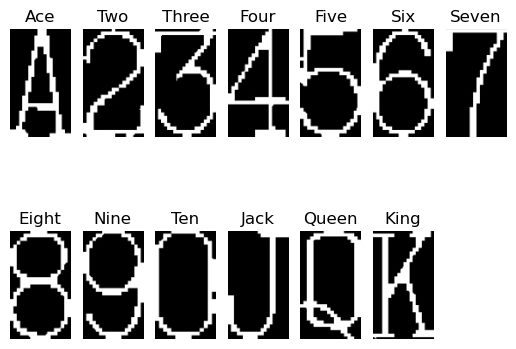

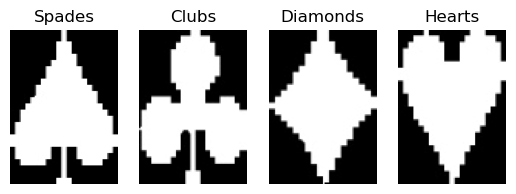

In [13]:
datapath = "self_data/"
rank_templates, suit_templates = Initialise_templates(datapath)
it = 0
for rank in rank_templates:
    plt.subplot(2,7,it+1)
    plt.imshow(rank_templates[it].image,cmap='gray')
    plt.title(rank_templates[it].name)
    plt.axis('off')
    it+=1
plt.show()

it = 0
for suit in suit_templates:
    plt.subplot(1,4,it+1)
    plt.imshow(suit_templates[it].image,cmap='gray')
    plt.title(suit_templates[it].name)
    plt.axis('off')
    it+=1

## Understanding suit and rank template extraction

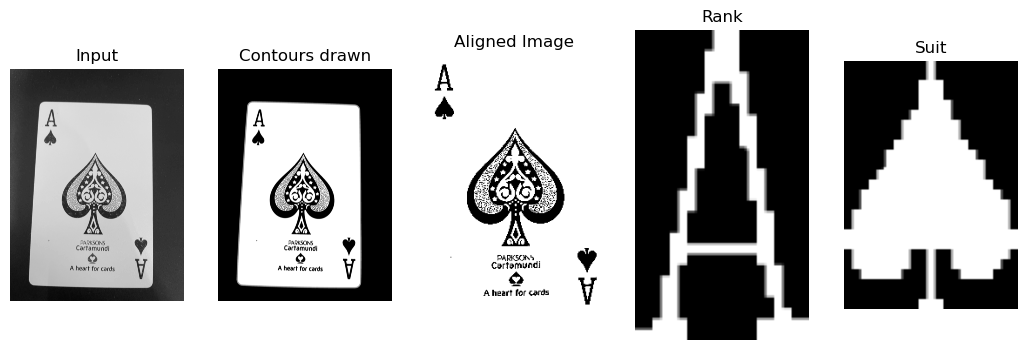

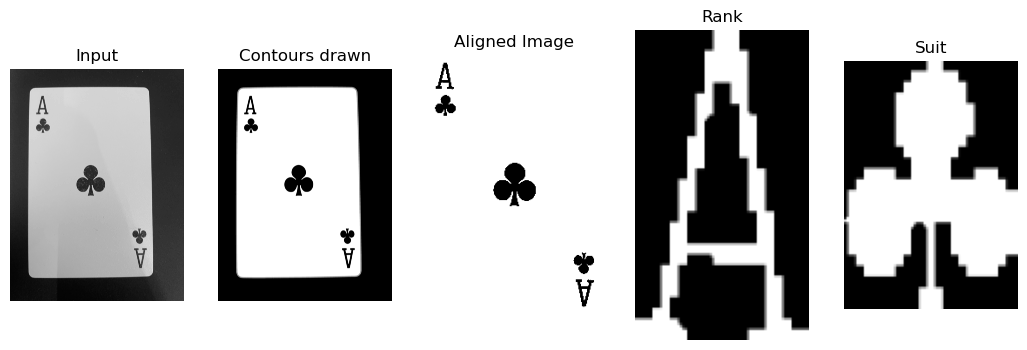

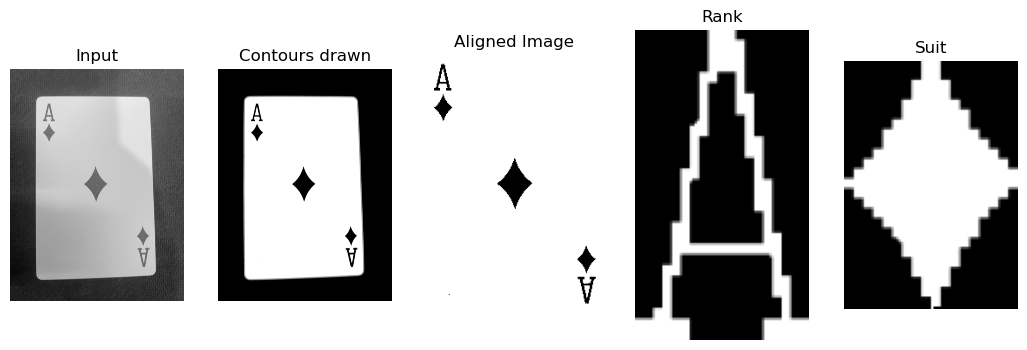

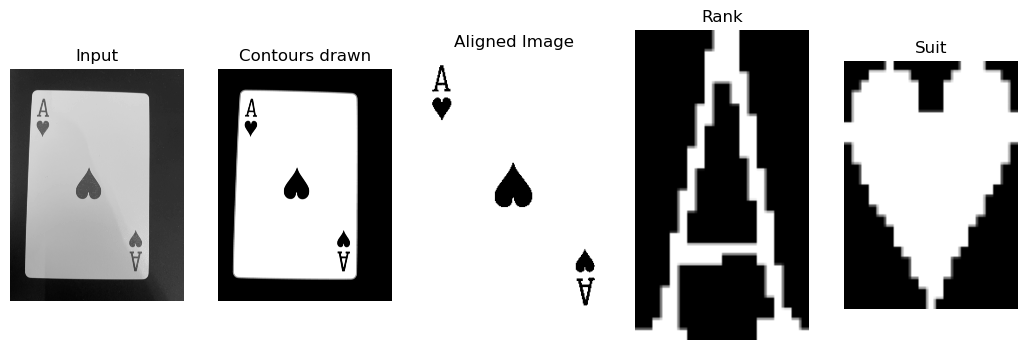

In [14]:
arr1 = ['A']
arr2 = ['spades', 'clubs', 'diamonds', 'hearts']

for r in arr1:
    for suit in arr2:
        image_in = cv2.imread("Train_Data_uncompressed/"+r+"_"+suit+".jpg",0)
        thresholded = threshold(image_in,150) 
        temp = thresholded.copy()
        cards,card_contour_check = find_card(thresholded)

        for i, c in enumerate(cards):
            if card_contour_check[i] == 1:
            # print("card found")
                cv2.drawContours(temp, cards, i, (150,150,150), 20)

        for i, c in enumerate(cards):
            if card_contour_check[i] == 1:
                card = extract_card(cards[i], thresholded)

        plt.figure(figsize=(13,8))
        plt.subplot(1,5,1)
        plt.imshow(image_in, cmap='gray')
        plt.title("Input")
        plt.axis('off')
        plt.subplot(1,5,2)
        plt.imshow(temp, cmap='gray')
        plt.title("Contours drawn")
        plt.axis('off')
        plt.subplot(1,5,3)
        plt.imshow(card.aligned, cmap='gray')
        plt.title("Aligned Image")
        plt.axis('off')
        plt.subplot(1,5,4)
        plt.imshow(card.rank_img, cmap='gray')
        plt.title("Rank")
        plt.axis('off')
        plt.subplot(1,5,5)
        plt.imshow(card.suit_img, cmap='gray')
        plt.title("Suit")
        plt.axis('off')
plt.show()

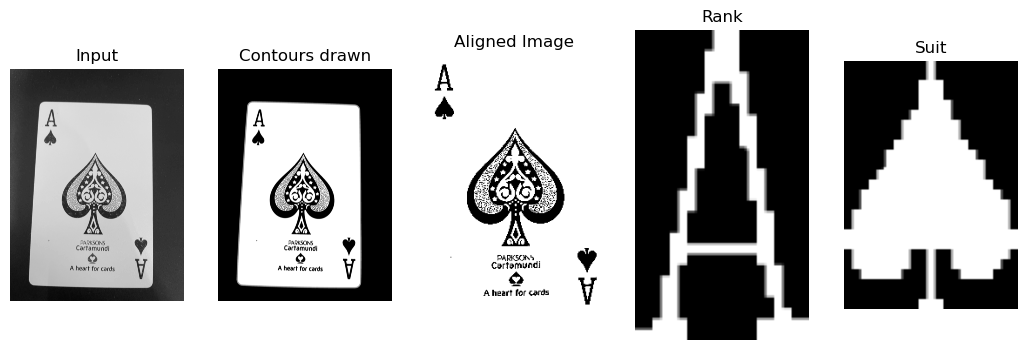

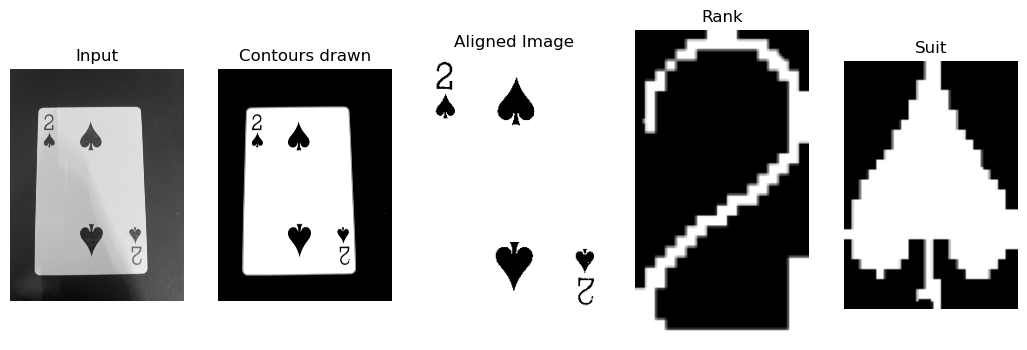

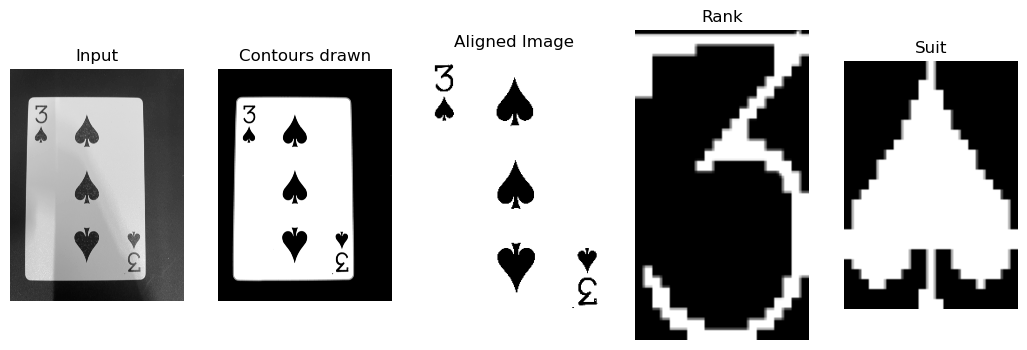

In [15]:
arr1 = ['A','2','3']
arr2 = ['spades']

for r in arr1:
    for suit in arr2:
        image_in = cv2.imread("Train_Data_uncompressed/"+r+"_"+suit+".jpg",0)
        thresholded = threshold(image_in,150) 
        temp = thresholded.copy()
        cards,card_contour_check = find_card(thresholded)

        for i, c in enumerate(cards):
            if card_contour_check[i] == 1:
            # print("card found")
                cv2.drawContours(temp, cards, i, (150,150,150), 20)

        for i, c in enumerate(cards):
            if card_contour_check[i] == 1:
                card = extract_card(cards[i], thresholded)

        plt.figure(figsize=(13,8))
        plt.subplot(1,5,1)
        plt.imshow(image_in, cmap='gray')
        plt.title("Input")
        plt.axis('off')
        plt.subplot(1,5,2)
        plt.imshow(temp, cmap='gray')
        plt.title("Contours drawn")
        plt.axis('off')
        plt.subplot(1,5,3)
        plt.imshow(card.aligned, cmap='gray')
        plt.title("Aligned Image")
        plt.axis('off')
        plt.subplot(1,5,4)
        plt.imshow(card.rank_img, cmap='gray')
        plt.title("Rank")
        plt.axis('off')
        plt.subplot(1,5,5)
        plt.imshow(card.suit_img, cmap='gray')
        plt.title("Suit")
        plt.axis('off')
plt.show()

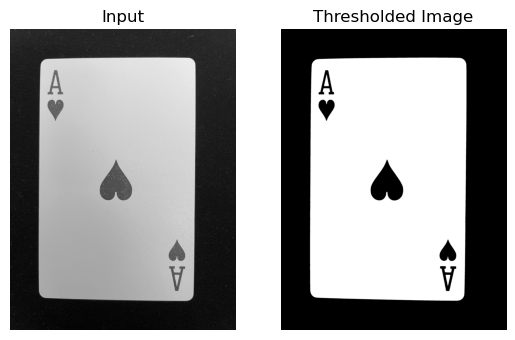

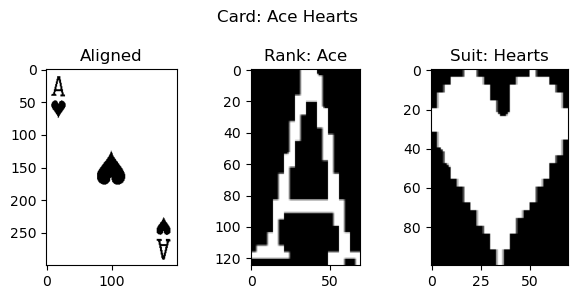

In [19]:
num = "4"
image_in = cv2.imread("Test_Data_uncompressed/image " + "("+(str)(num)+")" + ".jpg",0)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_in,cmap='gray')
plt.title("Input")
plt.axis('off')
thresholded = threshold(image_in,155)
temp = thresholded.copy()
plt.subplot(1,2,2)
plt.imshow(temp,cmap='gray')
plt.title("Thresholded Image")
plt.axis('off')
# start = time.time()
cards,card_contour_check = find_card(thresholded)

for i, c in enumerate(cards):
    if card_contour_check[i] == 1:
        card = extract_card(cards[i], thresholded)
        card = template_matching(card, rank_templates, suit_templates)
        # print(card.rank_pred, card.suit_pred)

        plt.figure(figsize=(6,3))
        plt.subplot(1, 3, 1)
        plt.imshow(card.aligned, cmap='gray')
        plt.title("Aligned")

        plt.subplot(1, 3, 2)
        plt.imshow(card.rank_img, cmap='gray')
        plt.title("Rank: " + card.rank_pred )
        plt.subplot(1, 3, 3)
        plt.imshow(card.suit_img, cmap='gray')
        plt.title("Suit: " + card.suit_pred)

        plt.suptitle("Card: " + card.rank_pred + " " + card.suit_pred)
        plt.tight_layout()

# end = time.time()
# runtime = end - start
# print(runtime)